In [1]:
%load_ext autoreload

In [2]:
%autoreload
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
from gpt.model import RevIN, AxialAttention, TransformerBlock, hMLP_stem, hMLP_output, LightningWrapper
from gpt.utils import flatten, nparams, get_time_pos_encoding
from einops import rearrange, pack, einsum
import torch.optim as optim
from tqdm.auto import tqdm
import matplotlib
from torchdiffeq import odeint as odeint
from torch.utils.data import TensorDataset, DataLoader
from lightning import pytorch as pl
from functools import partial

In [3]:
torch.set_float32_matmul_precision('medium')

# random sine waves

In [58]:
xs = torch.tensor(np.sort(np.random.uniform(0, 30, 120)), dtype=torch.float32)
# xs = torch.linspace(0, 30, 120, dtype=torch.float32)

num_series = 550_000
std = 0.1

periods = (0.2 + torch.rand(size=(num_series, 1)) * 0.5) * np.pi
phases = torch.rand(size=(num_series, 1)) * 2 * np.pi
offsets = torch.randn(size=(num_series, 1)) * 5
noise = torch.randn(size=(num_series, len(xs))) * std
_ys = torch.sin((xs.unsqueeze(0) + phases) / periods) + offsets + noise
ys = _ys.reshape(num_series, 1, -1).to(torch.float32)

# xsc, ysc = xs.cuda(), ys.cuda()

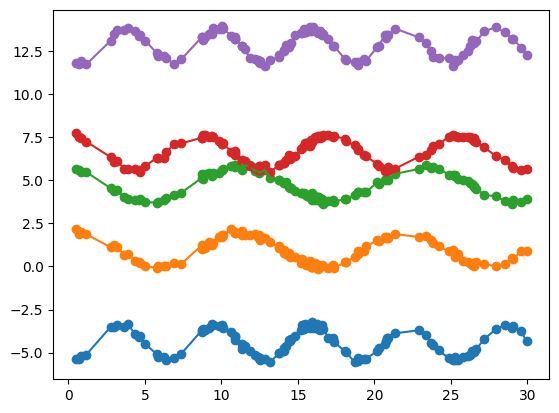

In [59]:
[plt.plot(xs, ys[i,0,:]) for i in range(5)]
[plt.scatter(xs, ys[i,0,:]) for i in range(5)]

In [291]:
class TiT(nn.Module): # time transformer
    def __init__(self, input_dim, embed_dim, num_heads, patch_size, mlp_ratio, dropout, num_blocks, reattention=False):
        super().__init__()
        self.embed_dim = embed_dim
        self.revin = RevIN(input_dim)
        self.time_patch_embed = hMLP_stem(patch_size=(patch_size,), in_chans=embed_dim // 4, embed_dim=embed_dim)
        self.input_head = nn.Conv1d(input_dim, embed_dim // 4, kernel_size=1, stride=1)
        self.patch_embed = hMLP_stem(patch_size=(patch_size,), in_chans=embed_dim // 4, embed_dim=embed_dim)
        self.dropout = nn.Dropout(dropout)
        self.blocks = nn.Sequential(*[TransformerBlock(num_heads, embed_dim, mlp_ratio, dropout, reattention=reattention) for _ in range(num_blocks)])
        self.norm = nn.LayerNorm(embed_dim)
        self.out_time_patch_embed = nn.Conv1d(embed_dim // 4, embed_dim, kernel_size=patch_size, stride=patch_size)
        self.output_head = hMLP_output(embed_dim=embed_dim, out_chans=input_dim, patch_size=(patch_size,))

    def forward(self, x, t, pool=False, out_t=None):
        norm_x, mean, std = self.revin.normalize(x)
        time_embed = get_time_pos_encoding(t.unsqueeze(-1), self.embed_dim // 4) # n d//4
        time_embed = self.time_patch_embed(time_embed.t()).t().unsqueeze(0) # 1 n//p d
        x = self.input_head(x) # b d//4 n
        x = self.patch_embed(x) # b d n//p
        x = rearrange(x, 'b c n -> b n c') # b n//p d
        x = self.dropout(x + time_embed)
        x = self.blocks(x)
        x = self.norm(x)
        if pool:
            x = x.mean(axis=1, keepdim=True)
        out_time_embed = get_time_pos_encoding((out_t if out_t is not None else t).unsqueeze(-1), self.embed_dim // 4) # n d//4
        out_time_embed = self.out_time_patch_embed(out_time_embed.t()).t().unsqueeze(0) # 1 n//p d
        x = x + out_time_embed
        x = self.output_head(x.transpose(1, 2))
        x = self.revin.unnormalize(x, mean, std)
        return x

    def step(self, batch, batch_idx=None):
        if len(batch) == 2: # autoencoder
            x, t = batch
            out = self(x, t, pool=False)
            return F.mse_loss(out, x)
        elif len(batch) == 4: # forecast
            x, t, y, out_t = batch
            out = self(x, t, pool=True, out_t=out_t)
            return F.mse_loss(out, y)

In [292]:
tit = LightningWrapper(
    TiT,
    input_dim=1, 
    embed_dim=64, 
    num_heads=4, 
    patch_size=4,
    mlp_ratio=4,
    dropout=0.1,
    num_blocks=2,
    lr=1e-3,
    warmup_steps=1000,
)

# autoencoder-style pretraining

In [274]:
def collate_fn(x):
    return torch.stack(list(map(lambda x: x[0], x))), xs[:80]

ds = TensorDataset(ys[:,:,:80])
trainset, testset = torch.utils.data.random_split(ds, [0.9, 0.1])
trainloader, testloader = map(partial(DataLoader, batch_size=2048, pin_memory=False, num_workers=0, collate_fn=collate_fn), (trainset, testset))

In [275]:
trainer = pl.Trainer(accelerator='gpu', precision='bf16-mixed', max_epochs=5)

/mnt/home/jshen/miniconda3/envs/gpt/lib/python3.11/site-packages/lightning/fabric/plugins/environments/slurm.py:204: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python3 /mnt/home/jshen/miniconda3/envs/gpt/lib/python3.11/ ...
Using bfloat16 Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


In [276]:
trainer.fit(tit, trainloader, testloader)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name  | Type | Params
-------------------------------
0 | model | TiT  | 86.8 K
-------------------------------
86.8 K    Trainable params
8         Non-trainable params
86.8 K    Total params
0.347     Total estimated model params size (MB)


Sanity Checking: |                                                                                            …

/mnt/home/jshen/miniconda3/envs/gpt/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=3` in the `DataLoader` to improve performance.
/mnt/home/jshen/miniconda3/envs/gpt/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=3` in the `DataLoader` to improve performance.


Training: |                                                                                                   …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

/mnt/home/jshen/miniconda3/envs/gpt/lib/python3.11/site-packages/torch/optim/lr_scheduler.py:156: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Validation: |                                                                                                 …

`Trainer.fit` stopped: `max_epochs=5` reached.


In [277]:
tit = tit.cuda()

In [278]:
with torch.no_grad():
    batch = next(iter(testloader))
    out = tit.model.forward(*map(lambda x: x.cuda(), batch)).cpu()

[[<matplotlib.lines.Line2D at 0x1553cca05ed0>],

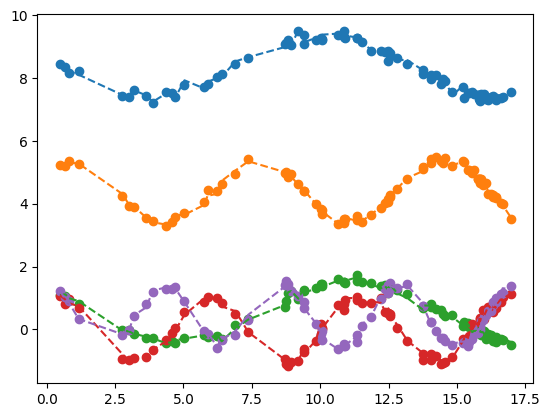

In [279]:
[plt.scatter(batch[1], batch[0][i,0]) for i in range(5)]
[plt.plot(batch[1], out[i,0], ls='--') for i in range(5)]

# ood autoencoding

In [280]:
def collate_fn(x):
    return torch.stack(list(map(lambda x: x[0], x))), xs

ds = TensorDataset(ys)
trainset, testset = torch.utils.data.random_split(ds, [0.9, 0.1])
trainloader, testloader = map(partial(DataLoader, batch_size=2048, pin_memory=False, num_workers=0, collate_fn=collate_fn), (trainset, testset))

In [281]:
with torch.no_grad():
    batch = next(iter(testloader))
    out = tit.model.forward(*map(lambda x: x.cuda(), batch)).cpu()

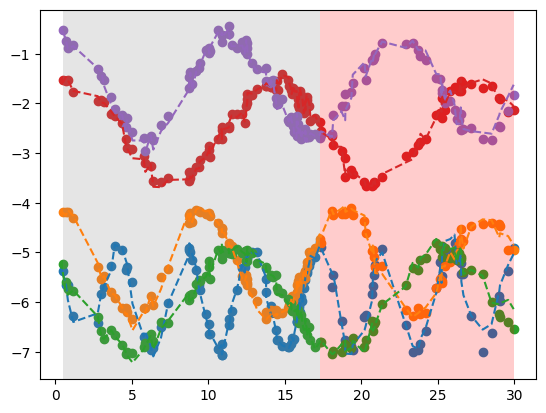

In [282]:
[plt.scatter(batch[1], batch[0][i,0]) for i in range(5)]
[plt.plot(batch[1], out[i,0], ls='--') for i in range(5)]
plt.axvspan(xs[0], xs[80], alpha=0.2, color='gray', lw=0)
plt.axvspan(xs[80], xs[-1], alpha=0.2, color='red', lw=0)

# zero shot forecasting

In [283]:
tit = tit.cuda()

In [284]:
with torch.no_grad():
    x, t = next(iter(testloader))
    y = x
    x, t = x.cuda(), t.cuda()
    x = x[:,:,:80]
    for i in range(10):
        print(i, x.shape, 80+i*4)
        out = tit.model.forward(x, t[:80+i*4], pool=True, out_t=t[80+i*4:80+(i+1)*4])
        x = torch.cat((x, out), dim=-1)
    x = x.cpu()
    t = t.cpu()

0 torch.Size([2048, 1, 80]) 80
1 torch.Size([2048, 1, 84]) 84
2 torch.Size([2048, 1, 88]) 88
3 torch.Size([2048, 1, 92]) 92
4 torch.Size([2048, 1, 96]) 96
5 torch.Size([2048, 1, 100]) 100
6 torch.Size([2048, 1, 104]) 104
7 torch.Size([2048, 1, 108]) 108
8 torch.Size([2048, 1, 112]) 112
9 torch.Size([2048, 1, 116]) 116


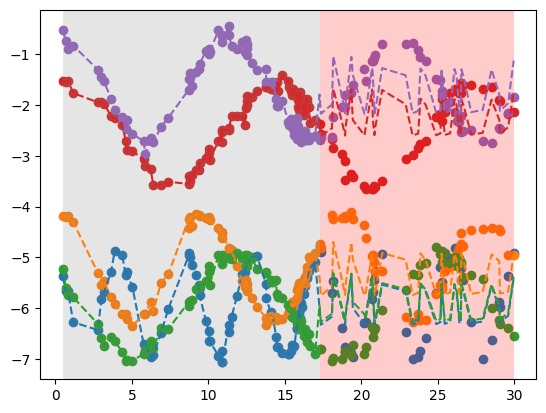

In [285]:
[plt.scatter(t, y[i,0]) for i in range(5)]
[plt.plot(t, x[i,0], ls='--') for i in range(5)]
plt.axvspan(xs[0], xs[80], alpha=0.2, color='gray', lw=0)
plt.axvspan(xs[80], xs[-1], alpha=0.2, color='red', lw=0)

# forecasting

In [293]:
def collate_fn(x):
    x = torch.stack(list(map(lambda x: x[0], x)))
    return x[:,:,:80], xs[:80], x[:,:,80:84], xs[80:84]

ds = TensorDataset(ys)
trainset, testset = torch.utils.data.random_split(ds, [0.9, 0.1])
trainloader, testloader = map(partial(DataLoader, batch_size=2048, pin_memory=False, num_workers=0, collate_fn=collate_fn), (trainset, testset))

In [294]:
trainer = pl.Trainer(accelerator='gpu', precision='bf16-mixed', max_epochs=15)

Using bfloat16 Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


In [295]:
trainer.fit(tit, trainloader, testloader)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name  | Type | Params
-------------------------------
0 | model | TiT  | 86.8 K
-------------------------------
86.8 K    Trainable params
8         Non-trainable params
86.8 K    Total params
0.347     Total estimated model params size (MB)


Sanity Checking: |                                                                                            …

Training: |                                                                                                   …

/mnt/home/jshen/miniconda3/envs/gpt/lib/python3.11/site-packages/torch/autograd/graph.py:744: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:919.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

`Trainer.fit` stopped: `max_epochs=15` reached.


In [296]:
def collate_fn(x):
    return torch.stack(list(map(lambda x: x[0], x))), xs

ds = TensorDataset(ys)
trainset, testset = torch.utils.data.random_split(ds, [0.9, 0.1])
trainloader, testloader = map(partial(DataLoader, batch_size=2048, pin_memory=False, num_workers=0, collate_fn=collate_fn), (trainset, testset))

In [298]:
tit = tit.cuda()

In [301]:
with torch.no_grad():
    x, t = next(iter(testloader))
    y = x
    x, t = x.cuda(), t.cuda()
    x = x[:,:,:80]
    for i in range(1):
        out = tit.model.forward(x, t[:80+i*4], pool=True, out_t=t[80+i*4:80+(i+1)*4])
        x = torch.cat((x, out), dim=-1)
    x = x.cpu()
    t = t.cpu()

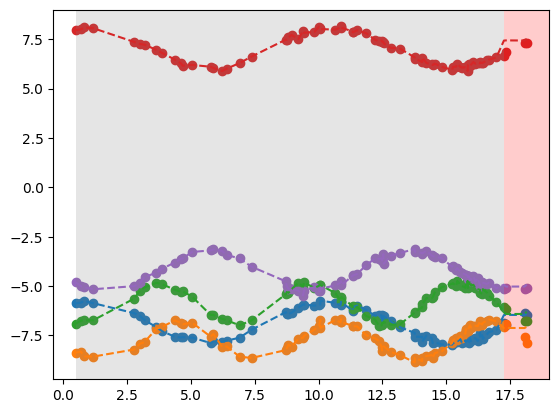

In [309]:
[plt.scatter(t[:84], y[i,0,:84]) for i in range(5)]
[plt.plot(t[:84], x[i,0], ls='--') for i in range(5)]
plt.axvspan(xs[0], xs[80], alpha=0.2, color='gray', lw=0)
plt.axvspan(xs[80], xs[-1], alpha=0.2, color='red', lw=0)